insider the main function


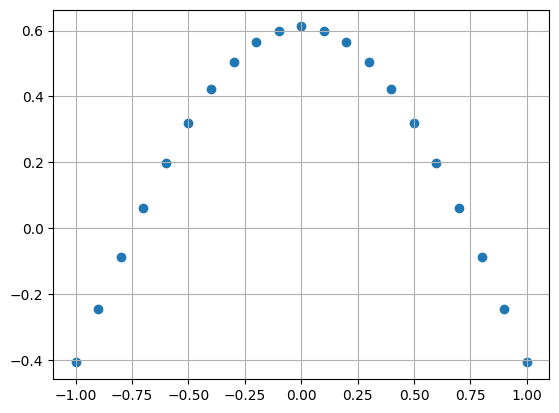

poly_norm = 1.013323462540281
uval = 17.668280353794568


In [1]:
import numpy as np
import scipy.special as sp
from numba import jit

import matplotlib
matplotlib.rcParams['image.cmap'] = 'jet'
import matplotlib.pyplot as plt


def compute_hermite_poly_norm(d):

    """
    Функция для вычисления нормы полинома Эрмита. 
    d - степень полинома Эрмита
    ...
    """

    if d >= 1:
        return compute_hermite_poly_norm(d - 1) * np.sqrt(d)    
    else:
        return 1.0

    return 1.0


def compute_hermite_polynomial(x, deg):

    """
    Функция для вычисления полинома Эрмита. 

    x - входное значение
    deg - степень полинома
    """

    return sp.eval_hermitenorm(deg, x) / compute_hermite_poly_norm(deg)


def compute_basis_function(x, deg):

    """
    Функция для вычисления базисной функции, которая в данном случае является полиномом Эрмита.

    x - входное значение
    deg - степень полинома
    """

    return compute_hermite_polynomial(x, deg)


def compute_design_matrix(deg_max, design_pparam):

    """
    Функция для вычисления матрицы дизайна, которая состоит из значений базисных функций на заданных точках.

    deg_max - максимальная степень полинома
    design_pparam - параметры дизайна
    """

    design_matrix = np.zeros((design_pparam.size, deg_max + 1))
    for idx in range(deg_max + 1):
        design_matrix[:, idx] = compute_basis_function(design_pparam, idx)

    return design_matrix


def compute_quadratic_form_post(design_matrix, sigma_pr, sigma_lh):

    """
    Функция для вычисления квадратичной формы для постериорного распределения.
    design_matrix - матрица дизайна
    sigma_pr - стандартное отклонение априорного распределения
    sigma_lh - стандартное отклонение правдоподобия
    """

    qmat = np.dot(np.transpose(design_matrix), design_matrix) / sigma_lh / sigma_lh
    qmat = qmat + np.eye(design_matrix.shape[1]) / sigma_pr / sigma_pr

    return qmat


def compute_mean_value_post(ydata, qmat, sigma_lh):

    """
    Функция для вычисления среднего значения постериорного распределения.

    ydata - данные
    qmat - квадратичная форма
    sigma_lh - стандартное отклонение правдоподобия
    """

    return np.linalg.solve(sigma_lh * sigma_lh * qmat, ydata)


def compute_kl_divergence(xdata, cdata, edata, sigma_pr, sigma_lh, deg_max):

    """
    Функция для вычисления дивергенции Кульбака-Лейблера между двумя распределениями.

    xdata - данные
    cdata - истинные значения коэффициентов
    edata - шум
    sigma_pr - стандартное отклонение априорного распределения
    sigma_lh - стандартное отклонение правдоподобия
    deg_max - максимальная степень полинома
    """

    ### polynomials are computed at xdata
    ### cdata - ground truth value of polyomial coefficients
    ### edata - noise
    design_matrix = compute_design_matrix(deg_max, xdata)
    qmat = compute_quadratic_form_post(design_matrix, sigma_pr, sigma_lh)
    ydata = np.dot(design_matrix, cdata) + edata
    c0 = compute_mean_value_post(np.dot(np.transpose(design_matrix), ydata), qmat, sigma_lh)
    cov_mat_ppost = np.linalg.inv(qmat)
    cov_mat_prior = sigma_pr * sigma_pr * np.eye(cdata.size)
    cov_mat_prior_inv = np.eye(cdata.size) / sigma_pr / sigma_pr
    kl_div = 0.0
    kl_div += 0.5 * np.trace(np.dot(cov_mat_prior_inv, cov_mat_ppost))
    kl_div -= 0.5 * cdata.size
    kl_div += 0.5 * np.sum(c0 * np.dot(cov_mat_prior_inv, c0))
    kl_div += 0.5 * np.log(np.linalg.det(cov_mat_prior)) - 0.5 * np.log(np.linalg.det(cov_mat_ppost))

    return kl_div


def compute_expected_information_gain(xdata, sigma_pr, sigma_lh, deg_max, nsample=10000):

    """
    Функция для вычисления ожидаемого информационного выигрыша.

    xdata - данные
    sigma_pr - стандартное отклонение априорного распределения
    sigma_lh - стандартное отклонение правдоподобия
    deg_max - максимальная степень полинома
   
    """

    kl_div_data = np.zeros((nsample))
    for idx in range(nsample):
        cdata = sigma_pr * np.random.normal(0.0, 1.0, 1 + deg_max)
        edata = sigma_lh * np.random.normal(0.0, 1.0, xdata.size)
        kl_div = compute_kl_divergence(xdata, cdata, edata, sigma_pr, sigma_lh, deg_max)
        # print(kl_div)
        kl_div_data[idx] = compute_kl_divergence(xdata, cdata, edata, sigma_pr, sigma_lh, deg_max)

    return np.mean(kl_div_data)


print('insider the main function')
x = np.linspace(-1.0, 1.0, 21)
d = 4
y = compute_hermite_polynomial(x, d)

plt.figure()
plt.scatter(x, y)
plt.grid()
plt.show()

x = np.random.normal(0.0, 1.0, 10000)
y = compute_hermite_polynomial(x, d)
poly_norm = np.sqrt(np.mean(y * y))
print('poly_norm = ' + str(poly_norm))

xdata = np.linspace(-1.0, 1.0, 5)
sigma_pr = 1.0
sigma_lh = 1.0e-2
deg_max = 3
uval = compute_expected_information_gain(xdata, sigma_pr, sigma_lh, deg_max, nsample=1000)
print('uval = ' + str(uval))


In [2]:
def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = tmp_val + h
        fxh1 = f(x)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) 
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val 
        
    return grad

def gradient_ascent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x += lr * grad
    return x


In [3]:
xdata = np.linspace(-1.0, 1.0, 5)

f = lambda x: compute_expected_information_gain(x, sigma_pr, sigma_lh, deg_max, nsample=1000)

optimized_x = gradient_ascent(f, xdata, lr=0.01, step_num=100)

In [10]:
def numerical_gradient_2(f, x):
    h = 1e-4
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = tmp_val + h
        fxh1 = f(x)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) 
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val 
        
    return grad


def gradient_ascent_2(f, init_x, lr=0.001, step_num=500):
    x = init_x
    x_history = []

    for i in range(step_num):
        x_history.append(x.copy())

        grad = numerical_gradient_2(f, x)
        x += lr * grad

    return x, np.array(x_history)


In [11]:
xdata = np.linspace(-1.0, 1.0, 5)
f = lambda x: compute_expected_information_gain(x, sigma_pr, sigma_lh, deg_max, nsample=1000)
init_x = np.array(xdata)
optimized_x, x_history = gradient_ascent_2(f, init_x, lr=0.001, step_num=500)


In [12]:
optimized_x

array([-1.93666724,  3.90178499, -6.62138154, -0.7901538 ,  1.39923775])

In [13]:
optimized_x_3_iter_500 = np.array([-1.93666724,  3.90178499, -6.62138154, -0.7901538 ,  1.39923775])

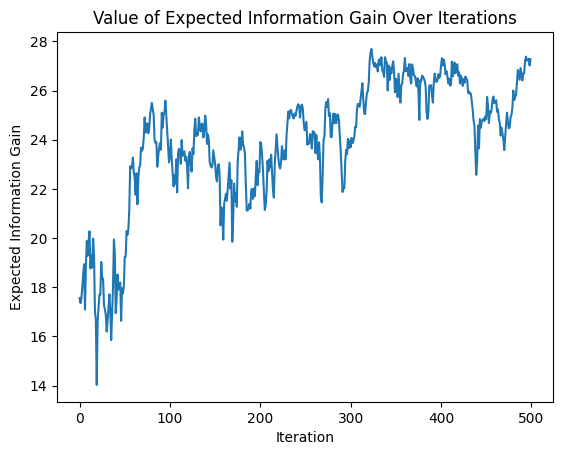

In [14]:
# Визуализация значений функции на каждом шаге
values = np.apply_along_axis(f, 1, x_history)
plt.plot(values)
plt.xlabel('Iteration')
plt.ylabel('Expected Information Gain')
plt.title('Value of Expected Information Gain Over Iterations')
plt.show()

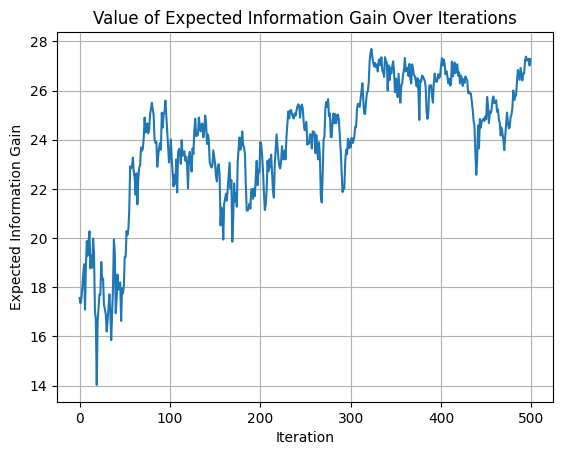

In [15]:
plt.plot(values)
plt.xlabel('Iteration')
plt.ylabel('Expected Information Gain')
plt.title('Value of Expected Information Gain Over Iterations')
plt.grid(True)
plt.show()

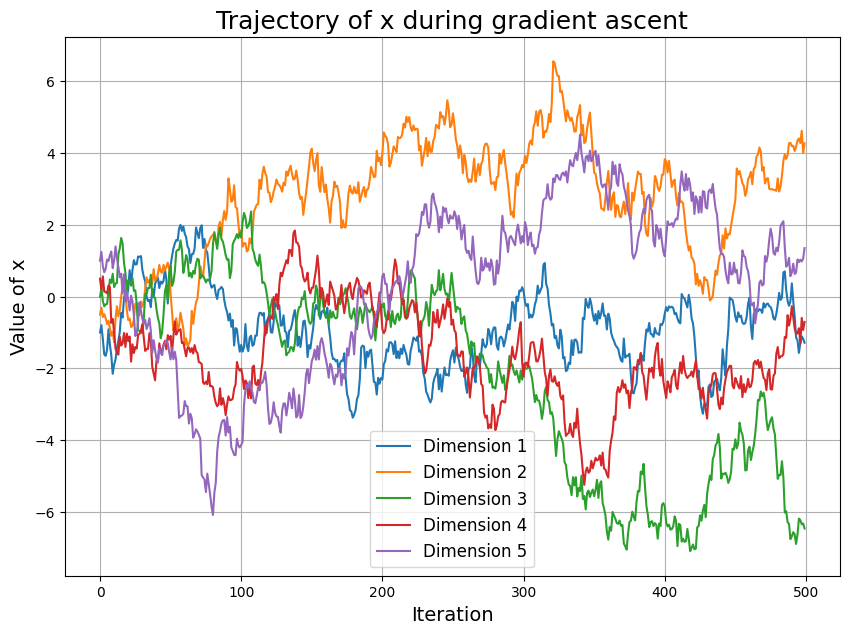

In [16]:
plt.figure(figsize=(10, 7))
for i in range(x_history.shape[1]):
    plt.plot(x_history[:, i], label=f'Dimension {i+1}')

plt.title('Trajectory of x during gradient ascent', fontsize=18)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Value of x', fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()


In [17]:
xdata = np.linspace(-1.0, 1.0, 5)
f = lambda x: compute_expected_information_gain(x, sigma_pr, sigma_lh, deg_max, nsample=1000)
init_x = np.array(xdata)
optimized_x_5_step_num, x_history = gradient_ascent_2(f, init_x, lr=0.001, step_num=300)


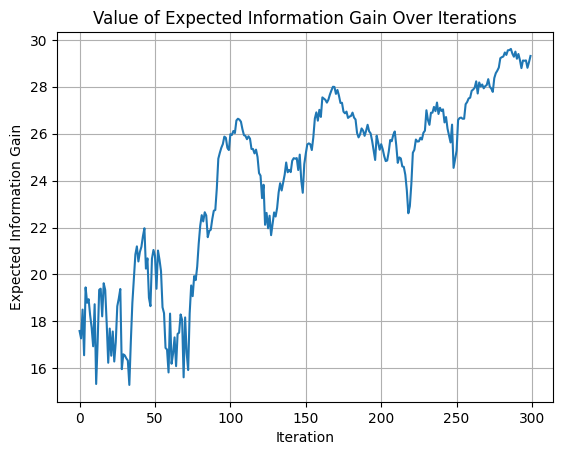

In [18]:
# Визуализация значений функции на каждом шаге
values = np.apply_along_axis(f, 1, x_history)
plt.plot(values)
plt.xlabel('Iteration')
plt.ylabel('Expected Information Gain')
plt.title('Value of Expected Information Gain Over Iterations')
plt.grid()
plt.show()

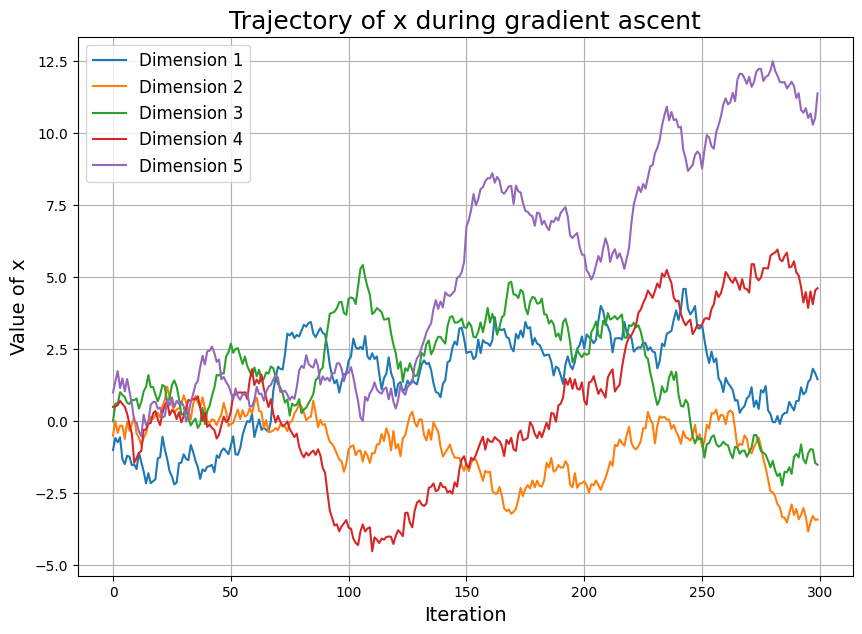

In [19]:
plt.figure(figsize=(10, 7))
for i in range(x_history.shape[1]):
    plt.plot(x_history[:, i], label=f'Dimension {i+1}')

plt.title('Trajectory of x during gradient ascent', fontsize=18)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Value of x', fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()


In [20]:
optimized_x_5_step_num

array([ 1.32519122, -3.31346968, -1.67277469,  4.924687  , 11.4062024 ])

In [42]:
x_5_300 = np.array([ 1.32519122, -3.31346968, -1.67277469,  4.9246874  , 11.4062024 ])
x_5_100 = np.array([-5.42293079,  3.6690781 ,  1.59768552,  0.16090725 , -2.83738361])
x_5_500 = np.array([3.17462856, 1.38563719, -0.375091911, -1.48275637, -3.184664109])

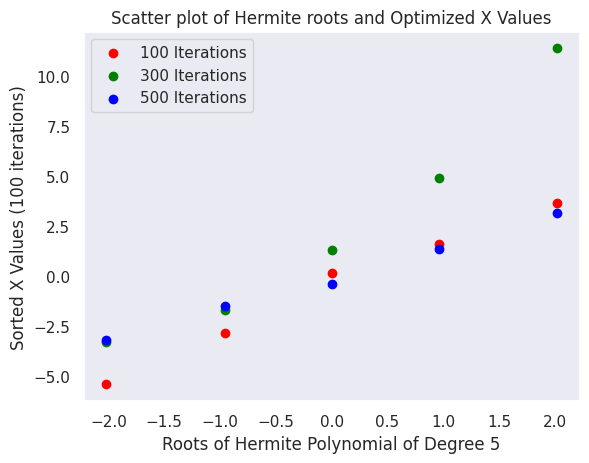

In [60]:
import scipy.special as sp

sns.set(style='darkgrid')

roots_hermite_5 = sp.roots_hermite(5, mu=False)

plt.figure()
plt.scatter((roots_hermite_5[0]), sorted(x_5_100), color='red')
plt.scatter((roots_hermite_5[0]), sorted(x_5_300), color='green')
plt.scatter((roots_hermite_5[0]), sorted(x_5_500), color='blue')
plt.grid()
plt.title('Scatter plot of Hermite roots and Optimized X Values')
plt.xlabel('Roots of Hermite Polynomial of Degree 5')
plt.ylabel('Sorted X Values (100 iterations)')
plt.legend(['100 Iterations', '300 Iterations', '500 Iterations'])
plt.show()


In [44]:
uval_5_100 = compute_expected_information_gain(x_5_100, sigma_pr, sigma_lh, deg_max, nsample=5000)
uval_5_300 = compute_expected_information_gain(x_5_300, sigma_pr, sigma_lh, deg_max, nsample=5000)
uval_5_500 = compute_expected_information_gain(x_5_100, sigma_pr, sigma_lh, deg_max, nsample=5000)

xdata = np.linspace(-1.0, 1.0, 5)
uval = compute_expected_information_gain(xdata, sigma_pr, sigma_lh, deg_max, nsample=5000)
print('uval 5 not optimized = ' + str(uval))

print('uval 5, nsaples = 1000 -> ' + str(uval_5_100))
print('uval 5, nsaples = 5000 -> ' + str(uval_5_300))
print('uval 5, nsaples = 10000 -> ' + str(uval_5_500))

uval 5 not optimized = 17.628901908040024
uval 5, nsaples = 1000 -> 26.71022189562885
uval 5, nsaples = 5000 -> 29.323008550948778
uval 5, nsaples = 10000 -> 26.735364979699906


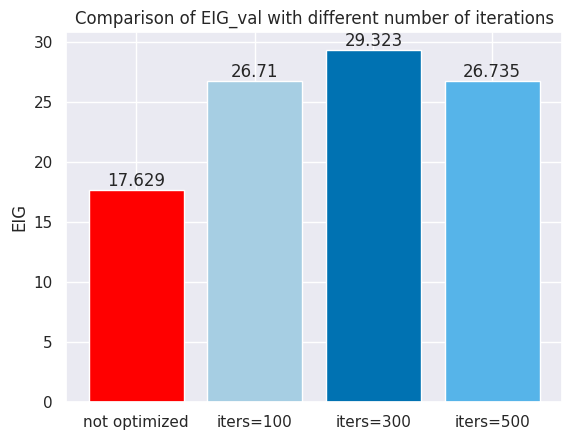

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')
# Значения uval
uval_5 = [round(uval, 3), round(uval_5_100, 3), round(uval_5_300, 3), round(uval_5_500, 3)]
labels = ['not optimized', 'iters=100', 'iters=300', 'iters=500']

# Создание диаграммы
fig, ax = plt.subplots()
ax.bar(labels, uval_5, color=['red', '#A6CEE3', '#0072B2', '#56B4E9'])

# Добавление подписей
for i, val in enumerate(uval_5):
    ax.text(i, val, str(val), ha='center', va='bottom')

# Настройки осей и заголовка
ax.set_ylabel('EIG')
ax.set_title('Comparison of EIG_val with different number of iterations')

plt.show()


In [21]:
xdata = np.linspace(-1.0, 1.0, 5)
f = lambda x: compute_expected_information_gain(x, sigma_pr, sigma_lh, deg_max, nsample=1000)
init_x = np.array(xdata)
optimized_x_5_step_num_100, x_history = gradient_ascent_2(f, init_x, lr=0.001, step_num=100)


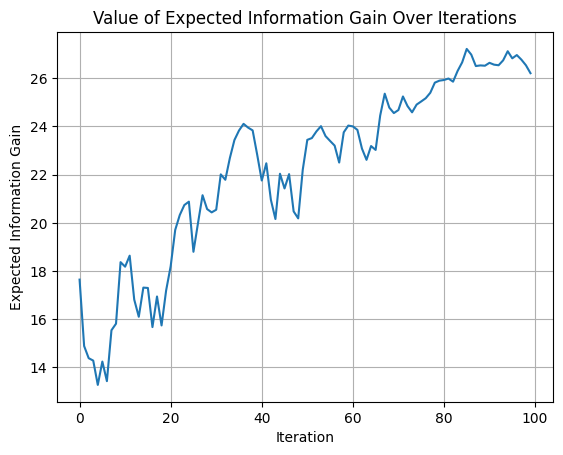

In [22]:
values = np.apply_along_axis(f, 1, x_history)
plt.plot(values)
plt.xlabel('Iteration')
plt.ylabel('Expected Information Gain')
plt.title('Value of Expected Information Gain Over Iterations')
plt.grid()
plt.show()

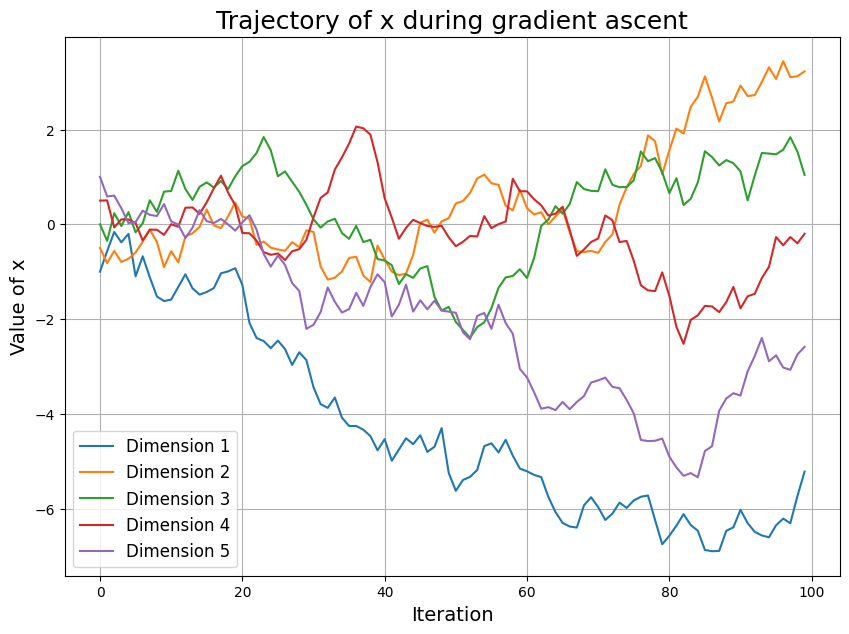

In [23]:
plt.figure(figsize=(10, 7))
for i in range(x_history.shape[1]):
    plt.plot(x_history[:, i], label=f'Dimension {i+1}')

plt.title('Trajectory of x during gradient ascent', fontsize=18)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Value of x', fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()


In [24]:
optimized_x_5_step_num_100

array([-5.42293079,  3.6690781 ,  1.59768552,  0.1609072 , -2.83738361])

In [25]:
xdata = np.linspace(-1.0, 1.0, 7)
f = lambda x: compute_expected_information_gain(x, sigma_pr, sigma_lh, deg_max, nsample=1000)
init_x = np.array(xdata)
optimized_x_7_step_num_100, x_history = gradient_ascent_2(f, init_x, lr=0.001, step_num=100)


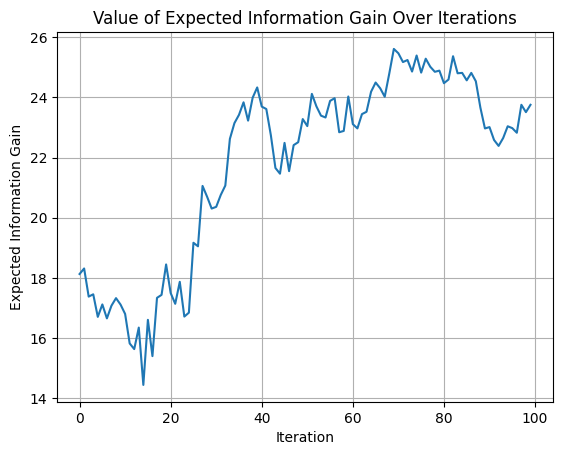

In [26]:
values = np.apply_along_axis(f, 1, x_history)
plt.plot(values)
plt.xlabel('Iteration')
plt.ylabel('Expected Information Gain')
plt.title('Value of Expected Information Gain Over Iterations')
plt.grid()
plt.show()

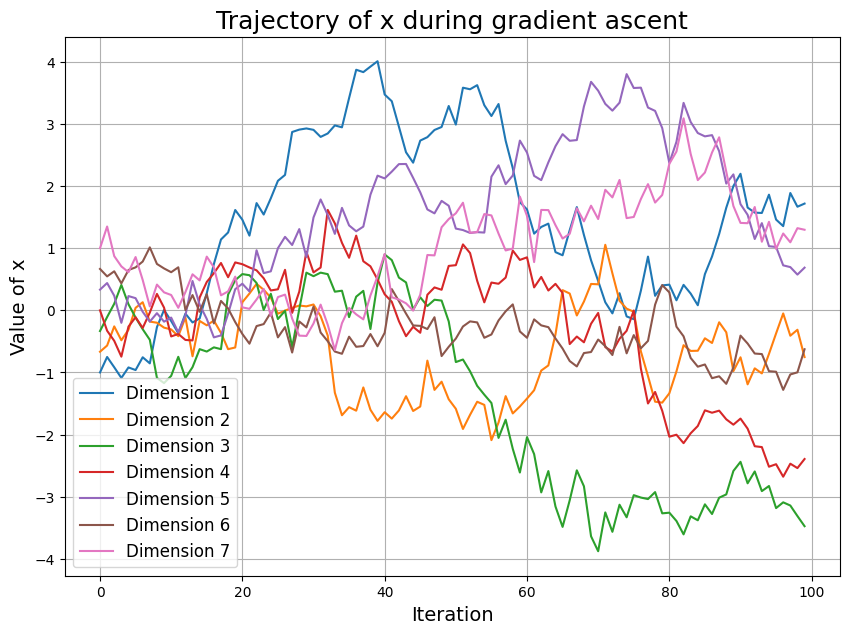

In [27]:
plt.figure(figsize=(10, 7))
for i in range(x_history.shape[1]):
    plt.plot(x_history[:, i], label=f'Dimension {i+1}')

plt.title('Trajectory of x during gradient ascent', fontsize=18)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Value of x', fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()


In [28]:
optimized_x_7_step_num_100

array([ 1.96268372, -0.22906427, -3.14881054, -2.4339412 ,  0.78903888,
       -0.30410218,  1.18750417])

In [29]:
xdata = np.linspace(-1.0, 1.0, 7)
f = lambda x: compute_expected_information_gain(x, sigma_pr, sigma_lh, deg_max, nsample=1000)
init_x = np.array(xdata)
optimized_x_7_step_num_300, x_history = gradient_ascent_2(f, init_x, lr=0.001, step_num=300)


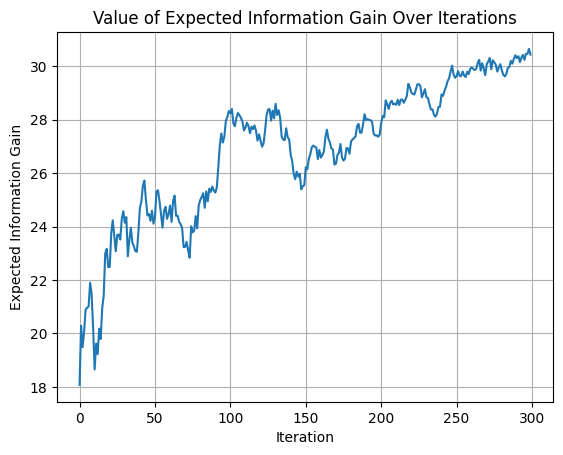

In [30]:
values = np.apply_along_axis(f, 1, x_history)
plt.plot(values)
plt.xlabel('Iteration')
plt.ylabel('Expected Information Gain')
plt.title('Value of Expected Information Gain Over Iterations')
plt.grid()
plt.show()

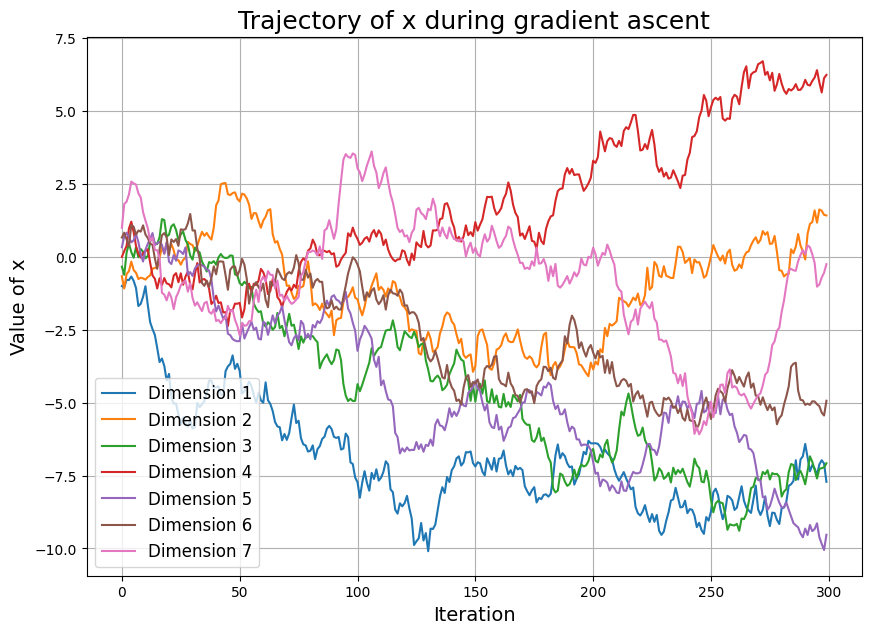

In [31]:
plt.figure(figsize=(10, 7))
for i in range(x_history.shape[1]):
    plt.plot(x_history[:, i], label=f'Dimension {i+1}')

plt.title('Trajectory of x during gradient ascent', fontsize=18)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Value of x', fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()


## next

In [3]:
x_3_1000 = np.array([  4.87208897, -11.93447335,  23.09875051])

x_3_5000 = np.array([-14.63389649, -18.69999947,  18.33078013])

x_3_10000 = np.array([ 6.80972392,  8.61538368, -3.16889888])

x_5_1000 = np.array([ 13.35274563,   5.35469246,  24.956637683, -12.85628502,
       -21.63936739])

x_5_5000 = np.array([ 16.64140809,   9.70799246,  31.76466692, -21.75588094,
       -20.00718843])

x_5_10000 = np.array([ -7.6923057 , -15.74641406,   7.65229763,  26.16693829,
        21.06019542])

x_7_1000 = np.array([  6.06590761,  51.68545953, -42.98953399, -72.8749245 ,
       -34.75291554, -28.93266456,   3.29197898])

x_7_5000 = np.array([  3.44105071, -12.07617325,  -3.41185574,  -6.28204115,
        24.21961955,  11.20786314,  21.86848078])

In [4]:
x_5_sample = np.array([2.32148573, 4.18573857, 5.92847385, -1.28474739, -2.84727465])

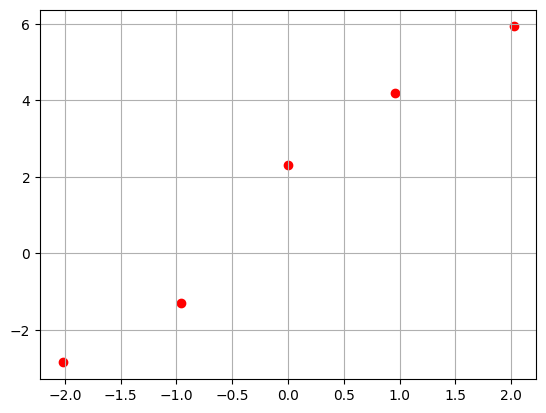

In [6]:
import scipy.special as sp


roots_hermite_5 = sp.roots_hermite(5, mu=False)

plt.figure()
plt.scatter((roots_hermite_5[0]), sorted(x_5_sample), color='red')
plt.grid()
plt.show()
# plt.scatter((roots_hermite_5[0]), sorted(optimized_x_5_5000), color='blue')
# plt.scatter((roots_hermite_5[0]), sorted(optimized_x_5_10000), color='green')

In [40]:
optimized_x

array([  6.06590761,  51.68545953, -42.98953399, -72.8749245 ,
       -34.75291554, -28.93266456,   3.29197898])

In [41]:
optimized_x_5_1000 = np.array([ 25.26287385,   0.46324582,  37.61008205,  -5.5959621 ,
       -16.89065846])

In [7]:
f = lambda x: compute_expected_information_gain(x, sigma_pr, sigma_lh, deg_max, nsample=5000)

optimized_x_5_5000 = gradient_ascent(f, xdata, lr=0.01, step_num=100)

In [8]:
optimized_x_5_5000

array([ 16.64140809,   9.70799246,  31.76466692, -21.75588094,
       -20.00718843])

In [9]:
xdata = np.linspace(-1.0, 1.0, 7)

f = lambda x: compute_expected_information_gain(x, sigma_pr, sigma_lh, deg_max, nsample=1000)

optimized_x = gradient_ascent(f, xdata, lr=0.01, step_num=100)

In [10]:
optimized_x_7_1000 = optimized_x

In [ ]:
x_3_1000 = np.array([  4.87208897, -11.93447335,  23.09875051])

x_3_5000 = np.array([-14.63389649, -18.69999947,  18.33078013])

x_3_10000 = np.array([ 6.80972392,  8.61538368, -3.16889888])

x_5_1000 = np.array([ 13.35274563,   5.35469246,  24.956637683, -12.85628502,
       -21.63936739])

x_5_5000 = np.array([ 16.64140809,   9.70799246,  31.76466692, -21.75588094,
       -20.00718843])

x_5_10000 = np.array([ -7.6923057 , -15.74641406,   7.65229763,  26.16693829,
        21.06019542])

x_7_1000 = np.array([  6.06590761,  51.68545953, -42.98953399, -72.8749245 ,
       -34.75291554, -28.93266456,   3.29197898])

x_7_5000 = np.array([  3.44105071, -12.07617325,  -3.41185574,  -6.28204115,
        24.21961955,  11.20786314,  21.86848078])

In [11]:
optimized_x_7_1000

array([  6.06590761,  51.68545953, -42.98953399, -72.8749245 ,
       -34.75291554, -28.93266456,   3.29197898])

In [12]:
xdata = np.linspace(-1.0, 1.0, 7)

f = lambda x: compute_expected_information_gain(x, sigma_pr, sigma_lh, deg_max, nsample=5000)

optimized_x_7_5000 = gradient_ascent(f, xdata, lr=0.01, step_num=100)

In [14]:
optimized_x_7_5000

array([  3.44105071, -12.07617325,  -3.41185574,  -6.28204115,
        24.21961955,  11.20786314,  21.86848078])

Сравнение результатов

Количество точек: 5



In [ ]:
xdata = np.linspace(-1.0, 1.0, 5)
uval = compute_expected_information_gain(xdata, sigma_pr, sigma_lh, deg_max, nsample=1000)
print('uval 5 not optimized = ' + str(uval))

In [15]:
xdata = np.linspace(-1.0, 1.0, 5)

In [16]:
uval = compute_expected_information_gain(xdata, sigma_pr, sigma_lh, deg_max, nsample=1000)
print('uval 5 not optimized = ' + str(uval))

uval 5 not optimized = 17.716905494580924


In [23]:
optimized_x_5_10000 = np.array([ -7.6923057 , -15.74641406,   7.65229763,  26.16693829,
        21.06019542])

In [42]:
uval_5_1000 = compute_expected_information_gain(optimized_x_5_1000, sigma_pr, sigma_lh, deg_max, nsample=1000)
uval_5_5000 = compute_expected_information_gain(optimized_x_5_5000, sigma_pr, sigma_lh, deg_max, nsample=1000)
uval_5_10000 = compute_expected_information_gain(optimized_x_5_10000, sigma_pr, sigma_lh, deg_max, nsample=1000)


print('uval 5, nsaples = 1000 -> ' + str(uval_5_1000))
print('uval 5, nsaples = 5000 -> ' + str(uval_5_5000))
print('uval 5, nsaples = 10000 -> ' + str(uval_5_10000))

uval 5, nsaples = 1000 -> 37.4867867095784
uval 5, nsaples = 5000 -> 36.483484571267425
uval 5, nsaples = 10000 -> 35.707963735782684


In [25]:
import scipy.special as sp


roots_hermite_5 = sp.roots_hermite(5, mu=False)

In [27]:
print(roots_hermite_5[0])

[-2.02018287 -0.95857246  0.          0.95857246  2.02018287]


In [43]:
optimized_x_5_1000

array([ 25.26287385,   0.46324582,  37.61008205,  -5.5959621 ,
       -16.89065846])

In [36]:
optimized_x_5_5000

array([ 16.64140809,   9.70799246,  31.76466692, -21.75588094,
       -20.00718843])

In [35]:
optimized_x_5_10000

array([ -7.6923057 , -15.74641406,   7.65229763,  26.16693829,
        21.06019542])

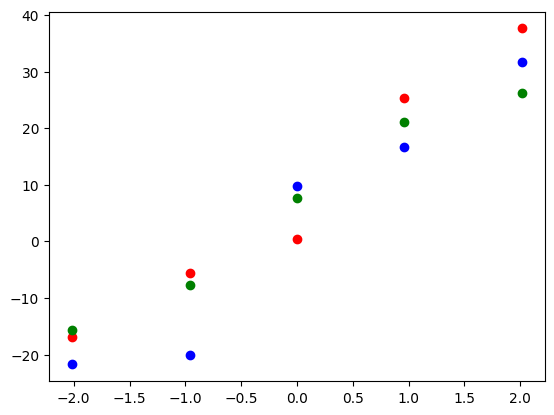

In [44]:
plt.scatter((roots_hermite_5[0]), sorted(optimized_x_5_1000), color='red')
plt.scatter((roots_hermite_5[0]), sorted(optimized_x_5_5000), color='blue')
plt.scatter((roots_hermite_5[0]), sorted(optimized_x_5_10000), color='green')

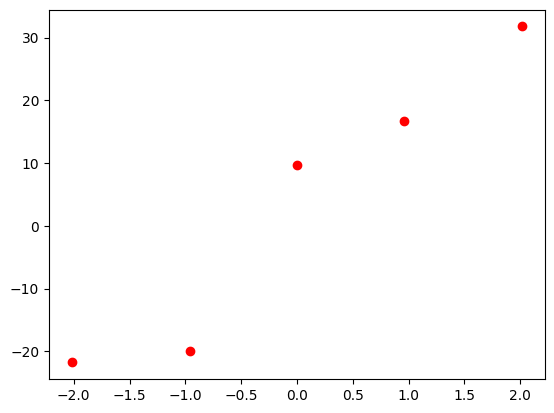

In [34]:
plt.scatter((roots_hermite_5[0]), sorted(optimized_x_5_1000), color='red')

In [45]:
xdata = np.linspace(-1.0, 1.0, 3)

In [46]:
optimized_x_3_1000 = np.array([4.87208897, -11.93447335,  23.09875051])
optimized_x_3_5000 = np.array([-14.63389649, -18.69999947,  18.33078013])
optimized_x_3_10000 = np.array([ 6.80972392,  8.61538368, -3.16889888])

In [48]:
uval = compute_expected_information_gain(xdata, sigma_pr, sigma_lh, deg_max, nsample=1000)
print('uval 3 not optimized = ' + str(uval))

uval 3 not optimized = 14.338612626823563


In [47]:
uval_3_1000 = compute_expected_information_gain(optimized_x_3_1000, sigma_pr, sigma_lh, deg_max, nsample=1000)
uval_3_5000 = compute_expected_information_gain(optimized_x_3_5000, sigma_pr, sigma_lh, deg_max, nsample=1000)
uval_3_10000 = compute_expected_information_gain(optimized_x_3_10000, sigma_pr, sigma_lh, deg_max, nsample=1000)


print('uval 3, nsaples = 1000 -> ' + str(uval_3_1000))
print('uval 3, nsaples = 5000 -> ' + str(uval_3_5000))
print('uval 3, nsaples = 10000 -> ' + str(uval_3_10000))

uval 3, nsaples = 1000 -> 29.062468414843085
uval 3, nsaples = 5000 -> 29.51167887333253
uval 3, nsaples = 10000 -> 23.107032799135226


In [49]:
import scipy.special as sp


roots_hermite_3 = sp.roots_hermite(3, mu=False)

In [ ]:
x = np.linspace(-1.0, 1.0, 21)
d = 4
y = compute_hermite_polynomial(x, d)

plt.figure()
plt.scatter(x, y)
plt.grid()
plt.show()

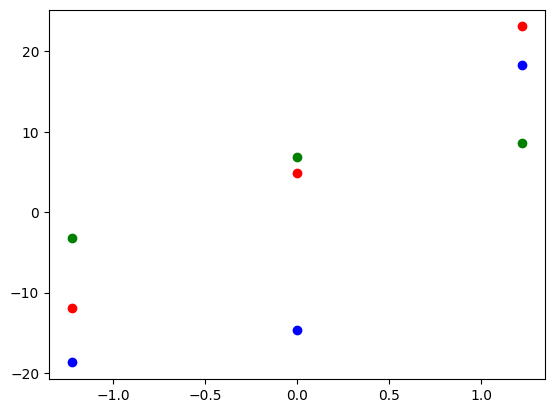

In [52]:
plt.scatter((roots_hermite_3[0]), sorted(optimized_x_3_1000), color='red')
plt.scatter((roots_hermite_3[0]), sorted(optimized_x_3_5000), color='blue')
plt.scatter((roots_hermite_3[0]), sorted(optimized_x_3_10000), color='green')

In [53]:
xdata = np.linspace(-1.0, 1.0, 7)

uval = compute_expected_information_gain(xdata, sigma_pr, sigma_lh, deg_max, nsample=1000)
print('uval 7 not optimized = ' + str(uval))

uval 7 not optimized = 18.14552089590299


In [55]:
uval_7_1000 = compute_expected_information_gain(optimized_x_7_1000, sigma_pr, sigma_lh, deg_max, nsample=1000)
uval_7_5000 = compute_expected_information_gain(optimized_x_7_5000, sigma_pr, sigma_lh, deg_max, nsample=1000)
# uval_7_10000 = compute_expected_information_gain(optimized_x_3_10000, sigma_pr, sigma_lh, deg_max, nsample=1000)


print('uval 7, nsaples = 1000 -> ' + str(uval_7_1000))
print('uval 7, nsaples = 5000 -> ' + str(uval_7_5000))
# print('uval 3, nsaples = 10000 -> ' + str(uval_3_10000))

uval 7, nsaples = 1000 -> 42.941782134208125
uval 7, nsaples = 5000 -> 35.43896627007799


In [61]:
import scipy.special as sp


roots_hermite_7 = sp.roots_hermite(7, mu=False)

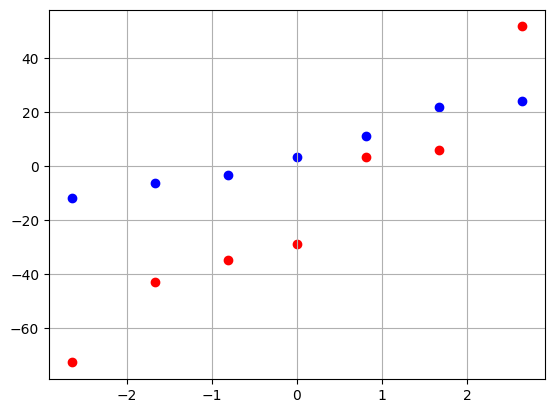

In [62]:
plt.figure()
plt.scatter((roots_hermite_7[0]), sorted(optimized_x_7_1000), color='red')
plt.scatter((roots_hermite_7[0]), sorted(optimized_x_7_5000), color='blue')
# plt.scatter((roots_hermite_7[0]), sorted(optimized_x_3_10000), color='green')
plt.grid()
plt.show()